In [0]:
import numpy as np
import pandas as pd

In [0]:

import torchvision
from fastai import *
from fastai.vision import *

In [0]:
def set_seed(seed=42):
    # python RNG
    import random
    random.seed(seed)

    # pytorch RNGs
    import torch
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    np.random.seed(seed)
    
set_seed()

In [0]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [0]:

def resnext50_32x4d(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = torchvision.models.resnext50_32x4d(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))

In [0]:
f_score = FBeta(average='weighted', beta=1)

In [0]:
#tfms = get_transforms(do_flip=False,flip_vert=False ,max_rotate=10.0, max_zoom=1.22, max_lighting=0.22, max_warp=0.0, p_affine=0.75, p_lighting=0.75,xtra_tfms=[rand_crop(), rand_zoom(1, 1.5),
                                 #symmetric_warp(magnitude=(-0.2, 0.2))])

In [0]:
tfms = get_transforms(do_flip=False,flip_vert=False ,max_rotate=10.0, max_zoom=1.22, max_lighting=0.22, max_warp=0.0, p_affine=0.75,
                      p_lighting=0.75)

In [0]:
np.random.seed(42)
src = (ImageList.from_csv('/content/drive/My Drive/DSL', 'train_dsl.csv', folder='images')
       .split_by_rand_pct(0.2, seed=42)
       .label_from_df(cols='category')
       .add_test(ImageList.from_csv('/content/drive/My Drive/DSL', csv_name='test_ApKoW4T.csv', folder='images'))
      )

In [0]:
def get_data(SZ, BS):
    data = (src.transform(tfms, size=SZ,padding_mode='reflection', resize_method=ResizeMethod.SQUISH)
        .databunch(bs=BS).normalize(imagenet_stats))
    return data

def get_learner(data):
    learn = cnn_learner(data, resnext50_32x4d, pretrained=True, cut=-2,
                        split_on=lambda m: (m[0][3], m[1]), 
                        metrics=[error_rate, f_score])
    return learn

In [0]:

data = get_data(128, 96)
learn = get_learner(data)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth


In [0]:
learn.mixup();

In [0]:
#learn.lr_find()
#learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(18, max_lr=slice(1e-2))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,1.909259,0.906360,0.314400,0.681154,54:19
1,1.506369,0.735292,0.265600,0.731967,00:48
2,1.208679,0.612683,0.227200,0.771176,00:45
3,1.052664,0.528361,0.217600,0.777836,00:45
4,0.979300,0.513334,0.200000,0.791484,00:46
5,0.902125,0.417530,0.147200,0.853086,00:46
6,0.838815,0.370745,0.132000,0.867133,00:46
7,0.798761,0.348715,0.118400,0.879643,00:45
8,0.744727,0.360623,0.123200,0.874964,00:45
9,0.709682,0.310521,0.103200,0.896400,00:46


In [0]:
learn.save('ResNext50_aug_mixup_128_920192')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 2.29E-05


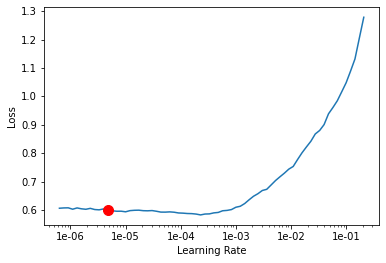

In [0]:

learn.unfreeze()
learn.clip_grad()
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:

learn.load('ResNext50_aug_mixup_128_920192');
learn.unfreeze();
learn.clip_grad();

In [0]:
lr = [3e-3/100, 3e-3/20, 3e-3/10]

In [0]:
learn.fit_one_cycle(36, lr)


epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.601274,0.276432,0.092000,0.907727,01:00
1,0.583736,0.270491,0.080000,0.920090,01:01
2,0.577389,0.270150,0.081600,0.918331,01:01
3,0.575857,0.270562,0.083200,0.916025,01:00
4,0.569142,0.248507,0.078400,0.921630,01:00
5,0.545523,0.267148,0.079200,0.920235,01:00
6,0.547545,0.246909,0.076000,0.924079,01:00
7,0.545298,0.264941,0.078400,0.920977,01:00
8,0.540591,0.232631,0.073600,0.926707,01:01
9,0.536161,0.316308,0.097600,0.900454,01:01


In [0]:
learn.save('s2_ResNext50_aug_128_944603')

In [0]:
data = get_data(256, 72)
learn = get_learner(data)

In [0]:

learn.load('s2_ResNext50_aug_128_944603');

In [0]:

learn.freeze();
learn.clip_grad();

In [0]:
learn.loss_func = FocalLoss()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 1.00E-02


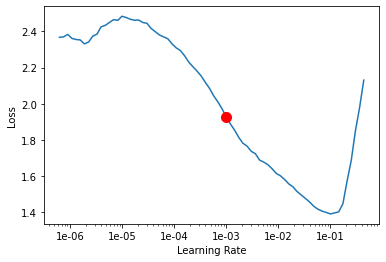

In [0]:

learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(24, slice(3e-3))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.902625,0.459033,0.209600,0.786635,02:28
1,0.611762,0.347636,0.168000,0.831019,02:26
2,0.501663,0.310563,0.174400,0.825018,02:26
3,0.386222,0.257353,0.148800,0.850157,02:26
4,0.258213,0.186908,0.130400,0.868029,02:26
5,0.199952,0.149384,0.115200,0.885792,02:26
6,0.153744,0.147448,0.120800,0.880102,02:26
7,0.140906,0.138058,0.120800,0.880627,02:26
8,0.104841,0.120579,0.100000,0.900308,02:26
9,0.087498,0.122534,0.092800,0.908106,02:26


In [0]:
learn.save('ResNxt50_FL_128t256_962240')

In [0]:
learn.load('ResNxt50_FL_128t256_962240');

In [0]:

learn.unfreeze()
learn.clip_grad()

In [0]:
 
lr = [1e-3/100, 1e-3/20, 1e-3/10]
learn.fit_one_cycle(32, lr)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.015993,0.094990,0.060800,0.939371,03:26
1,0.013113,0.100979,0.062400,0.937898,03:23
2,0.012794,0.101759,0.063200,0.936992,03:23
3,0.011179,0.112778,0.067200,0.933382,03:23
4,0.012484,0.110631,0.066400,0.933917,03:23
5,0.015234,0.117082,0.063200,0.937021,03:23
6,0.016921,0.132815,0.060000,0.940198,03:23
7,0.013386,0.101004,0.055200,0.945044,03:23
8,0.017902,0.151236,0.073600,0.927177,03:23
9,0.019634,0.108778,0.050400,0.949896,03:23


In [0]:
learn.save('ResNxt50_FL_s2128t256_963172')

In [0]:
data = get_data(299, 52)
learn = get_learner(data)

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/checkpoints/resnext50_32x4d-7cdf4587.pth


In [0]:
learn.load('ResNxt50_FL_s2128t256_963172');
learn.freeze();
learn.clip_grad();

In [0]:
learn.mixup();

epoch,train_loss,valid_loss,error_rate,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.98E-03


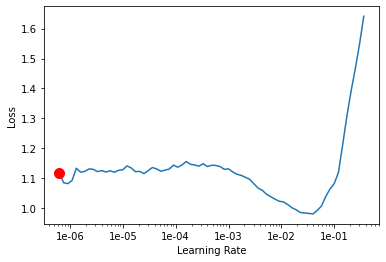

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [0]:
learn.fit_one_cycle(32, slice(2e-3))

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,1.034053,0.149400,0.047200,0.952632,12:56
1,0.708515,0.188758,0.047200,0.952904,01:52
2,0.563393,0.166325,0.041600,0.958416,01:51
3,0.532917,0.156031,0.042400,0.957533,01:51
4,0.502277,0.149163,0.037600,0.962281,01:51
5,0.507152,0.156014,0.043200,0.956722,01:51
6,0.501088,0.149999,0.041600,0.958233,01:51
7,0.500819,0.147356,0.040800,0.959199,01:51
8,0.486784,0.152888,0.039200,0.960856,01:50
9,0.487796,0.133895,0.037600,0.962319,01:51


In [0]:

learn.save('ResNext50_FL_128t224t299_s1_965518')

In [0]:
learn.load('ResNext50_FL_128t224t299_s1_965518');

In [0]:

learn.unfreeze()
learn.clip_grad();

In [0]:
lr = [3e-3/100, 3e-3/20, 3e-3/10]
learn.fit_one_cycle(64, lr)

epoch,train_loss,valid_loss,error_rate,f_beta,time
0,0.442806,0.121806,0.030400,0.969524,02:24
1,0.436974,0.119794,0.029600,0.970338,02:32
2,0.430586,0.121030,0.027200,0.972785,02:33
3,0.444784,0.123571,0.032800,0.967203,02:33
4,0.440546,0.118896,0.032800,0.967117,02:33
5,0.444794,0.117019,0.032000,0.968070,02:34
6,0.445547,0.130154,0.035200,0.964970,02:33
7,0.439427,0.139230,0.040800,0.959166,02:32
8,0.438499,0.134147,0.038400,0.961548,02:33
9,0.444220,0.131262,0.033600,0.966443,02:32


Wide resnet implementation


In [0]:
def wideresnet(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = torchvision.models.wide_resnet101_2(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))

In [0]:
def get_learner_wide(data):
    learn = cnn_learner(data, wideresnet, pretrained=True, cut=-2,
                        split_on=lambda m: (m[0][3], m[1]), 
                        metrics=[error_rate, f_score, accuracy])
    return learn

In [0]:
data=get_data(249,32)
learn_wide=get_learner_wide(data)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-03
Min loss divided by 10: 3.31E-03


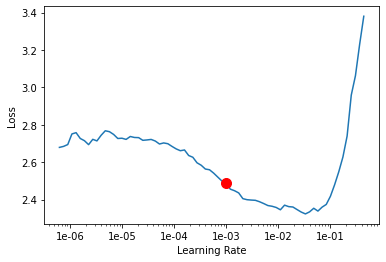

In [12]:
learn_wide.mixup()
learn_wide.lr_find()
learn_wide.recorder.plot(suggestion=True)

In [13]:
learn_wide.fit_one_cycle(10,max_lr=slice(1e-02))

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,1.467155,0.748013,0.261600,0.734681,0.738400,21:35
1,1.028167,0.493138,0.188000,0.812062,0.812000,05:03
2,0.892125,0.445405,0.164000,0.837215,0.836000,05:03
3,0.777204,0.254892,0.079200,0.920525,0.920800,05:03
4,0.673703,0.250621,0.084000,0.916639,0.916000,05:03
5,0.632849,0.238415,0.078400,0.919797,0.921600,05:03
6,0.606458,0.216916,0.070400,0.929196,0.929600,05:03
7,0.572462,0.177560,0.057600,0.942467,0.942400,05:03
8,0.557347,0.177504,0.052000,0.947838,0.948000,05:03
9,0.546161,0.175651,0.059200,0.940611,0.940800,05:03


epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 4.79E-07


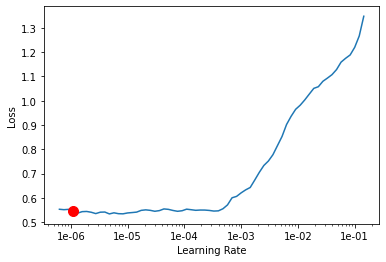

In [14]:
learn_wide.unfreeze()
learn_wide.clip_grad()
learn_wide.lr_find()
learn_wide.recorder.plot(suggestion=True)

In [0]:
lr=[3e-3/100, 3e-3/20, 3e-3/10]

In [17]:
learn_wide.fit_one_cycle(12, lr, wd=0.1)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.544618,0.182859,0.053600,0.946465,0.946400,07:27
1,0.620668,0.249570,0.089600,0.909706,0.910400,07:27
2,0.634457,0.352732,0.115200,0.884323,0.884800,07:27
3,0.645739,0.361360,0.112800,0.885651,0.887200,07:27
4,0.598013,0.221740,0.067200,0.932604,0.932800,07:27
5,0.558989,0.196610,0.067200,0.933554,0.932800,07:26
6,0.528400,0.190037,0.064000,0.936283,0.936000,07:26
7,0.485431,0.166803,0.048000,0.952306,0.952000,07:26
8,0.469151,0.148016,0.044800,0.955407,0.955200,07:27
9,0.442654,0.130765,0.039200,0.960923,0.960800,07:28


In [0]:
learn_wide.save('widerestnet_249_1306')

In [0]:
learn_wide.load('widerestnet_249_1306')

In [0]:
data=get_data(349,16)
learn_wide=get_learner_wide(data)

In [0]:
learn_wide.freeze();
learn_wide.clip_grad();
learn_wide.mixup();

In [0]:
learn_wide.loss_func = FocalLoss()

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-05
Min loss divided by 10: 1.10E-03


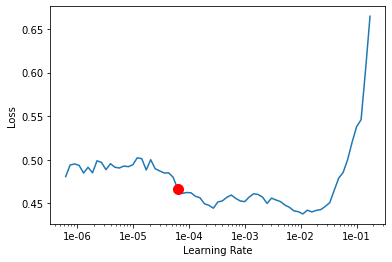

In [17]:
learn_wide.lr_find()
learn_wide.recorder.plot(suggestion=True)

In [19]:
learn_wide.fit_one_cycle(10,max_lr=slice(2e-04))

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.429370,0.068544,0.036000,0.964183,0.964000,10:49
1,0.328409,0.060461,0.042400,0.957769,0.957600,10:45
2,0.304015,0.076126,0.039200,0.960972,0.960800,10:44
3,0.313848,0.083458,0.035200,0.965005,0.964800,10:45
4,0.301235,0.088032,0.040000,0.960177,0.960000,10:45
5,0.312359,0.085192,0.044800,0.955422,0.955200,10:44
6,0.300634,0.089839,0.035200,0.964941,0.964800,10:44
7,0.299145,0.089740,0.040800,0.959363,0.959200,10:48
8,0.292893,0.093123,0.042400,0.957729,0.957600,10:46
9,0.303142,0.087176,0.036000,0.964131,0.964000,10:45


In [0]:
learn_wide.save('widerestnet_249__349_1306')

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 3.31E-07


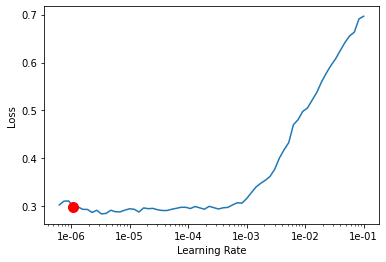

In [21]:
learn_wide.unfreeze()
learn_wide.clip_grad()
learn_wide.lr_find()
learn_wide.recorder.plot(suggestion=True)

In [25]:
predsTTA, _ = learn_res_152.TTA(ds_type=DatasetType.Test)

In [0]:
predTTA_df = pd.DataFrame(predsTTA.numpy(), columns=data.classes)
preds_class_TTA = np.argmax(predTTA_df.values, axis=1)
preds_class_TTA += 1

In [0]:
#num_class={1:'Cargo',2:'Military', 3:'Carrier', 4:'Cruiser', 5:'Tanks'}

In [0]:
def write_submission(preds, filename):
    sub = pd.read_csv('/content/drive/My Drive/DSL/test_ApKoW4T.csv')
    sub['category'] = preds
    sub.to_csv(filename, index=False)

In [0]:
write_submission(preds_class_TTA, 'TTA_wideresnet_.csv')

Resnet 152



In [0]:
def resnet101(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = torchvision.models.resnet101(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))

def get_learner_res_101(data):
    learn = cnn_learner(data, resnet101, pretrained=True, cut=-2,
                        split_on=lambda m: (m[0][3], m[1]), 
                        metrics=[error_rate, f_score, accuracy])
    return learn

In [14]:
data=get_data(224,64)
learn_res_101=get_learner_res_101(data)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


In [0]:
learn_res_101.mixup()
#learn_res_101.lr_find()
#learn_res_101.recorder.plot(suggestion=True)

In [16]:
learn_res_101.fit_one_cycle(12,max_lr=slice(3e-02))

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,1.276793,0.422332,0.167200,0.830199,0.832800,32:42
1,0.958463,0.421394,0.138400,0.861198,0.861600,00:49
2,0.848452,0.302695,0.099200,0.900781,0.900800,00:47
3,0.731348,0.253706,0.092800,0.906874,0.907200,00:47
4,0.663997,0.265154,0.082400,0.918697,0.917600,00:47
5,0.628651,0.263184,0.081600,0.918902,0.918400,00:46
6,0.610359,0.226864,0.077600,0.923137,0.922400,00:47
7,0.585407,0.210942,0.064800,0.935046,0.935200,00:47
8,0.535995,0.170653,0.049600,0.950387,0.950400,00:46
9,0.515960,0.166898,0.052000,0.947917,0.948000,00:46


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


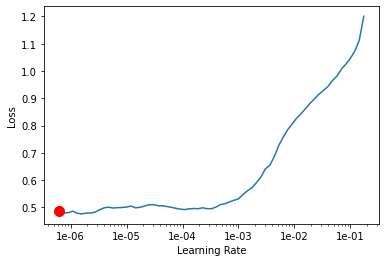

In [17]:
learn_res_101.unfreeze()
learn_res_101.clip_grad()
learn_res_101.lr_find()
learn_res_101.recorder.plot(suggestion=True)

In [0]:
lr=[3e-3/100, 3e-3/20, 3e-3/10]

In [20]:
learn_res_101.fit_one_cycle(20, lr )

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.493714,0.157852,0.046400,0.953650,0.953600,00:58
1,0.496271,0.188442,0.057600,0.942788,0.942400,00:58
2,0.501030,0.222464,0.078400,0.921340,0.921600,00:58
3,0.523252,0.201294,0.065600,0.934192,0.934400,00:58
4,0.545877,0.309275,0.092800,0.908489,0.907200,00:58
5,0.532738,0.212287,0.072000,0.928457,0.928000,00:58
6,0.525151,0.501205,0.149600,0.836294,0.850400,00:58
7,0.503085,0.218099,0.061600,0.938102,0.938400,00:58
8,0.495890,0.220774,0.067200,0.932823,0.932800,00:58
9,0.484925,0.234059,0.074400,0.924946,0.925600,00:58


In [0]:
learn_res_101.save('resnet_101_224')

In [0]:

learn_res_101.freeze_to(-3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.92E-07


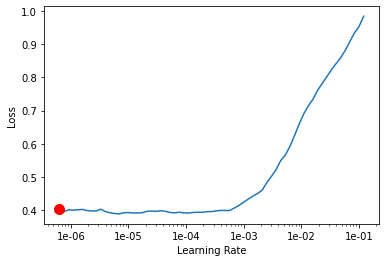

In [24]:
learn_res_101.lr_find()
learn_res_101.recorder.plot(suggestion=True)

In [25]:
learn_res_101.fit_one_cycle(6, slice(1e-06, 1e-04),wd=0.1)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.411914,0.142696,0.039200,0.960847,0.960800,00:57
1,0.395679,0.139256,0.034400,0.965619,0.965600,00:57
2,0.397473,0.141723,0.036000,0.964002,0.964000,00:57
3,0.401476,0.146098,0.036000,0.964101,0.964000,00:58
4,0.400007,0.144373,0.038400,0.961679,0.961600,00:57
5,0.394615,0.145913,0.040800,0.959183,0.959200,00:57


In [0]:
learn_res_101.freeze_to(-2)

In [27]:
learn_res_101.fit_one_cycle(6, slice(5e-07, 1e-04/20),wd=0.1)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.396021,0.150318,0.037600,0.962437,0.962400,00:57
1,0.394688,0.148053,0.038400,0.961622,0.961600,00:57
2,0.406025,0.148619,0.040000,0.960028,0.960000,00:57
3,0.393746,0.143968,0.036000,0.964129,0.964000,00:57
4,0.394992,0.143969,0.037600,0.962398,0.962400,00:57
5,0.392006,0.148244,0.039200,0.960833,0.960800,00:57


In [0]:
learn_res_101.freeze_to(-1)

In [29]:
learn_res_101.fit_one_cycle(5, slice(1e-07, 1e-04/30),wd=0.05)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.385966,0.142850,0.034400,0.965672,0.965600,00:46
1,0.389131,0.142140,0.037600,0.962484,0.962400,00:46
2,0.390483,0.142973,0.036000,0.964029,0.964000,00:46
3,0.391241,0.142293,0.036000,0.964054,0.964000,00:46
4,0.388141,0.145684,0.037600,0.962471,0.962400,00:46


In [0]:
learn_res_101.save('resnet_101_224_14-06')

In [0]:
data=get_data(299,32)
learn_res_101=get_learner_res_101(data)

In [0]:
learn_res_101.load('resnet_101_224_14-06')

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-03


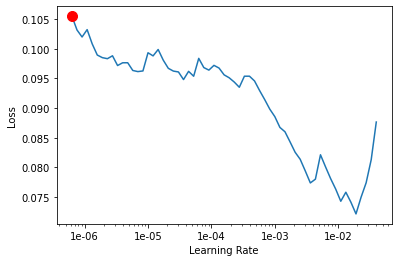

In [45]:
learn_res_101.freeze();
learn_res_101.clip_grad();
learn_res_101.lr_find()
learn_res_101.recorder.plot(suggestion=True)

In [46]:
learn_res_101.fit_one_cycle(10, max_lr=slice(2e-03))

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.044461,0.136391,0.039200,0.960840,0.960800,01:17
1,0.016245,0.182872,0.035200,0.964815,0.964800,01:15
2,0.012792,0.209128,0.036000,0.963996,0.964000,01:14
3,0.004515,0.284465,0.033600,0.966516,0.966400,01:15
4,0.010886,0.284136,0.037600,0.962320,0.962400,01:15
5,0.011829,0.303089,0.034400,0.965627,0.965600,01:14
6,0.013296,0.303936,0.035200,0.964779,0.964800,01:15
7,0.007990,0.318170,0.035200,0.964839,0.964800,01:15
8,0.013375,0.321901,0.035200,0.964830,0.964800,01:15
9,0.010587,0.311472,0.034400,0.965630,0.965600,01:15


epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


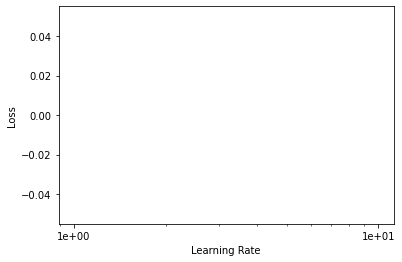

In [49]:
learn_res_101.unfreeze()
learn_res_101.lr_find()
learn_res_101.recorder.plot(suggestion=True)

In [50]:
learn_res_101.fit_one_cycle(15,slice(1e-05,3e-03/8),wd=0.15)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.009867,0.286944,0.032000,0.968003,0.968000,01:36
1,0.016439,0.292246,0.035200,0.964793,0.964800,01:36
2,0.045528,0.295139,0.039200,0.960771,0.960800,01:36
3,0.043560,0.532027,0.064000,0.934640,0.936000,01:37
4,0.078436,0.506431,0.063200,0.937228,0.936800,01:37
5,0.065056,0.355942,0.047200,0.952842,0.952800,01:38
6,0.054290,0.387665,0.047200,0.952816,0.952800,01:37
7,0.032340,0.317467,0.048800,0.951396,0.951200,01:37
8,0.031657,0.281685,0.040000,0.960238,0.960000,01:38
9,0.019327,0.316547,0.040800,0.959335,0.959200,01:37


In [0]:
learn_res_101.freeze_to(-3)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Failed to compute the gradients, there might not be enough points.


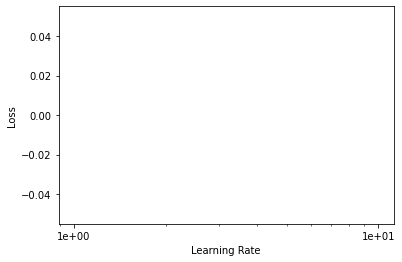

In [52]:
learn_res_101.lr_find()
learn_res_101.recorder.plot(suggestion=True)

In [53]:
learn_res_101.fit_one_cycle(6, slice(1e-06, 3e-03/10),wd=0.1)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.001148,0.310239,0.038400,0.961624,0.961600,01:37
1,0.007286,0.348276,0.040800,0.959221,0.959200,01:37
2,0.001607,0.337621,0.043200,0.956784,0.956800,01:37
3,0.006254,0.321867,0.041600,0.958482,0.958400,01:36
4,0.000654,0.318767,0.037600,0.962435,0.962400,01:36
5,0.000085,0.317867,0.037600,0.962431,0.962400,01:36


In [0]:
learn_res_101.freeze_to(-2)

In [55]:
learn_res_101.fit_one_cycle(6, slice(5e-07, 3e-3/20),wd=0.1)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.000206,0.322360,0.038400,0.961689,0.961600,01:37
1,0.000320,0.323249,0.040800,0.959181,0.959200,01:36
2,0.002085,0.316569,0.035200,0.964777,0.964800,01:36
3,0.000179,0.307680,0.038400,0.961607,0.961600,01:36
4,0.000323,0.303116,0.036000,0.963995,0.964000,01:35
5,0.001591,0.310071,0.036800,0.963249,0.963200,01:35


In [0]:
learn_res_101.freeze_to(-1)

In [56]:
learn_res_101.fit_one_cycle(5, slice(1e-07, 3e-3/30),wd=0.1)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.000054,0.310602,0.037600,0.962422,0.962400,01:36
1,0.000147,0.318964,0.034400,0.965638,0.965600,01:36
2,0.000261,0.319280,0.036800,0.963191,0.963200,01:35
3,0.000095,0.315874,0.036800,0.963201,0.963200,01:35
4,0.000420,0.319535,0.036800,0.963229,0.963200,01:35


In [0]:
learn_res_101.save('resnet_101_final')

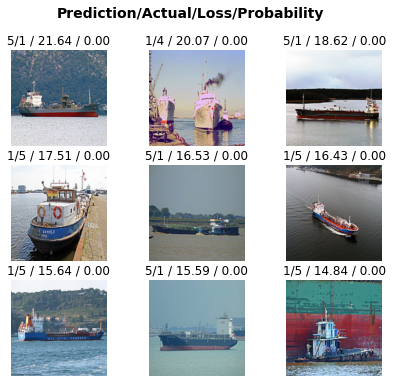

In [62]:
interp = ClassificationInterpretation.from_learner(learn_res_101)
interp.plot_top_losses(9, figsize=(7,6))

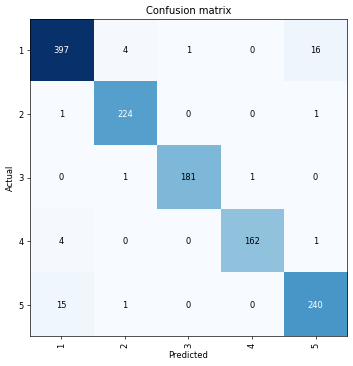

In [64]:

interp.plot_confusion_matrix(figsize=(6,6), dpi=60)

Resnet 152

In [0]:
def resnet152(pretrained=False):
    pretrained = 'imagenet' if pretrained else None
    model = torchvision.models.resnet152(pretrained=pretrained)
    return nn.Sequential(*list(model.children()))

def get_learner_res_152(data):
    learn = cnn_learner(data, resnet152, pretrained=True, cut=-2,
                        split_on=lambda m: (m[0][3], m[1]), 
                        metrics=[error_rate, f_score, accuracy])
    return learn

In [0]:
data=get_data(299,32)
learn_res_152=get_learner_res_152(data)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.91E-04
Min loss divided by 10: 1.10E-03


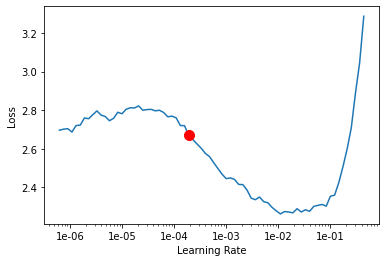

In [11]:
learn_res_152.mixup()
learn_res_152.lr_find()
learn_res_152.recorder.plot(suggestion=True)

In [12]:
learn_res_152.fit_one_cycle(10, max_lr=slice(1e-02))

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,1.328841,0.491092,0.178400,0.821661,0.821600,01:37
1,0.886393,0.337352,0.116800,0.882660,0.883200,01:35
2,0.817891,0.269221,0.091200,0.908573,0.908800,01:34
3,0.707106,0.246524,0.080000,0.919896,0.920000,01:34
4,0.640995,0.193437,0.056800,0.943270,0.943200,01:34
5,0.593493,0.211384,0.064800,0.935728,0.935200,01:34
6,0.565707,0.172795,0.052800,0.947574,0.947200,01:34
7,0.527276,0.170076,0.052000,0.948000,0.948000,01:34
8,0.504962,0.168070,0.052800,0.947131,0.947200,01:34
9,0.500295,0.164766,0.049600,0.950325,0.950400,01:34


epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-06
Min loss divided by 10: 8.32E-07


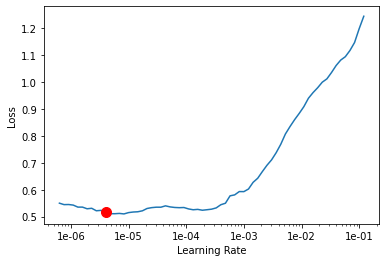

In [13]:
learn_res_152.unfreeze()
learn_res_152.clip_grad()
learn_res_152.lr_find()
learn_res_152.recorder.plot(suggestion=True)

In [15]:
learn_res_152.fit_one_cycle(16, max_lr=slice(1e-06, 1e-05), wd=0.1)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.507500,0.167784,0.051200,0.949018,0.948800,02:09
1,0.508062,0.165942,0.047200,0.952986,0.952800,02:08
2,0.494176,0.166804,0.049600,0.950364,0.950400,02:09
3,0.506837,0.165593,0.050400,0.949782,0.949600,02:08
4,0.480865,0.166248,0.049600,0.950590,0.950400,02:08
5,0.473109,0.164858,0.044000,0.955920,0.956000,02:08
6,0.495612,0.162532,0.044000,0.956030,0.956000,02:09
7,0.470698,0.158861,0.044800,0.955199,0.955200,02:08
8,0.473549,0.160807,0.044800,0.955258,0.955200,02:09
9,0.467443,0.158352,0.044000,0.955978,0.956000,02:08


In [0]:
learn_res_152.save('resnet_152_299')

In [0]:
learn_res_152.freeze_to(-3)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.75E-06
Min loss divided by 10: 4.79E-07


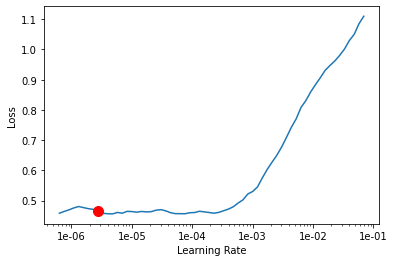

In [21]:
learn_res_152.lr_find()
learn_res_152.recorder.plot(suggestion=True)

In [22]:
learn_res_152.fit_one_cycle(6, slice(4e-06, 3e-03/10),wd=0.1)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.458202,0.156536,0.046400,0.953609,0.953600,02:09
1,0.495099,0.161745,0.047200,0.952867,0.952800,02:09
2,0.480537,0.151982,0.034400,0.965574,0.965600,02:09
3,0.459459,0.151584,0.039200,0.960807,0.960800,02:09
4,0.443474,0.154611,0.040800,0.959110,0.959200,02:09
5,0.444805,0.138522,0.034400,0.965552,0.965600,02:09


In [23]:
learn_res_152.freeze_to(-2)
learn_res_152.fit_one_cycle(5, slice(4e-07, 3e-03/20),wd=0.05)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.438602,0.136275,0.032800,0.967190,0.967200,02:10
1,0.436017,0.137894,0.035200,0.964776,0.964800,02:09
2,0.439419,0.133986,0.037600,0.962374,0.962400,02:08
3,0.427657,0.138631,0.039200,0.960649,0.960800,02:08
4,0.449908,0.132552,0.036000,0.964031,0.964000,02:08


In [24]:
learn_res_152.freeze_to(-1)
learn_res_152.fit_one_cycle(5, slice(1e-07, 3e-03/30),wd=0.05)

epoch,train_loss,valid_loss,error_rate,f_beta,accuracy,time
0,0.458636,0.133937,0.038400,0.961561,0.961600,01:37
1,0.417577,0.133880,0.036000,0.963949,0.964000,01:37
2,0.424280,0.135182,0.036000,0.963931,0.964000,01:37
3,0.423553,0.132784,0.035200,0.964764,0.964800,01:37
4,0.434508,0.133818,0.035200,0.964807,0.964800,01:37


In [0]:
learn_res_152.save('res_152_299')